In [1]:
import os.path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from gensim.downloader import load
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist #used to determine number of tokens
from gensim.models import Word2Vec

In [2]:
with open("goemotions.json", "r") as read_content:
    file = pd.read_json(read_content)

Taking count of all sentiment and emotion tags respectively associated with Reddit posts. Then creating a dictionary to create key-value pairings.

In [3]:
print(file.loc[file[0]=='They have THE BEST tortillas too. Made right in front of you. Mmmmmm!'])

                                                        0           1  \
264     They have THE BEST tortillas too. Made right i...     neutral   
23540   They have THE BEST tortillas too. Made right i...     neutral   
73369   They have THE BEST tortillas too. Made right i...  admiration   
86008   They have THE BEST tortillas too. Made right i...  admiration   
115605  They have THE BEST tortillas too. Made right i...    approval   

               2  
264      neutral  
23540    neutral  
73369   positive  
86008   positive  
115605  positive  


In [4]:
sentiment = file[2].value_counts().to_dict()
sentiment_values = sentiment.keys()
sentiment_frequency = sentiment.values()

In [5]:
emotion = file[1].value_counts().to_dict()
emotion_values = emotion.keys()
emotion_frequency = emotion.values()

In [6]:
# print(emotion)
# emotion_list = list(emotion_frequency)
# pdP = pd.Series(emotion_list)
# print(pdP.describe())

In [7]:
# print(sentiment)
# sentiment_list = list(sentiment_frequency)
# pdP = pd.Series(sentiment_list) 
# print(pdP.describe())

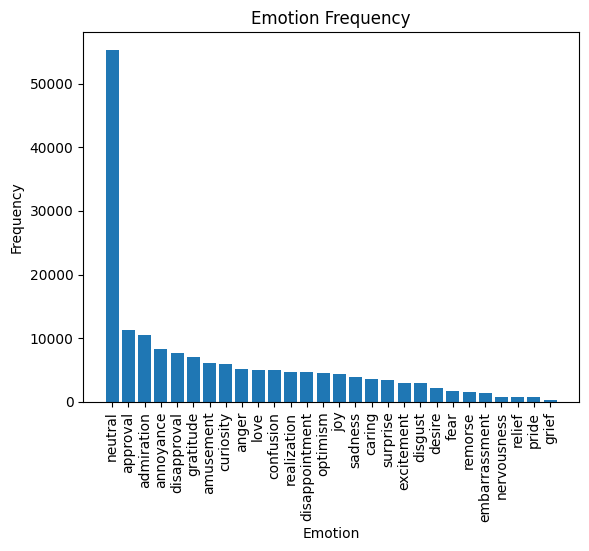

In [8]:
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.title("Emotion Frequency")
plt.xticks(rotation= 90) #done for readbility purposes
plt.bar(emotion_values, emotion_frequency)
plt.savefig("bar_emotion.png")
plt.show()

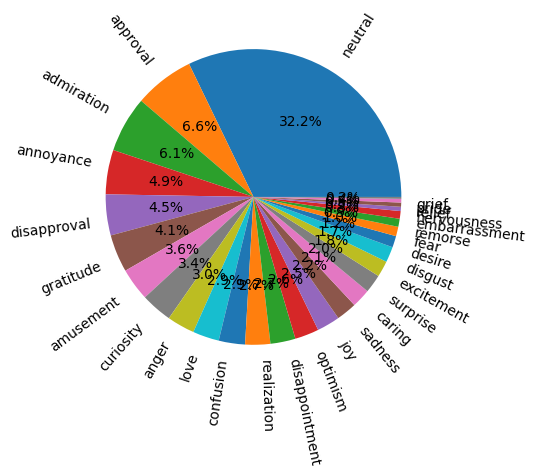

In [9]:
emotionLabels = []
sizes = []
for x, y in emotion.items():
    emotionLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=emotionLabels, rotatelabels = True, autopct ='%1.1f%%')
plt.savefig("pie_emotion.png")
plt.show()


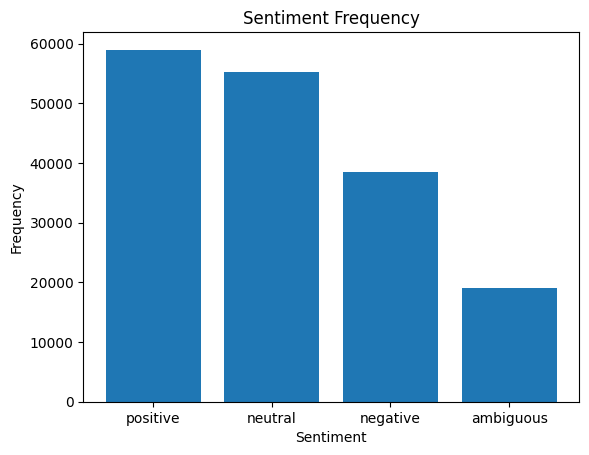

In [10]:
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Frequency")
plt.bar(sentiment_values, sentiment_frequency)
plt.savefig("bar_sentiment.png")
plt.show()

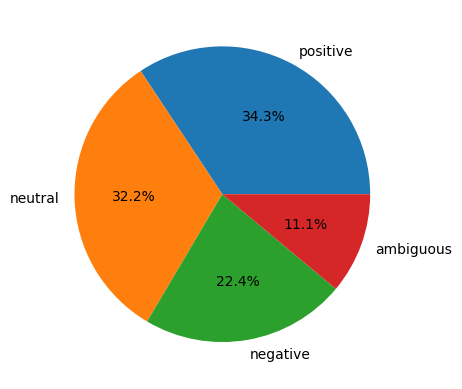

In [11]:
sentimentLabels = []
sizes = []
for x, y in sentiment.items():
    sentimentLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=sentimentLabels, autopct ='%1.1f%%')
plt.savefig("pie_sentiment.png")
plt.show()


Plotting of Frequency vs. Emotion and Frequency vs. Sentiment <br>
Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

<h1>extract tokens/words</h1>

In [12]:
post = file[0].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(post)
# vectorizer.get_feature_names_out()

In [13]:
print(f"The number of unique words is {len(X.toarray()[0])} unique words")

The number of unique words is 30449 unique words


Given that when X.toarray() is used, the occurrences of words in a post is counted for example <br> "This document is the second document."<br> the word document is used twice [0 2 0 1 0 1 1 0 1] mapping to the array of unique words ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
<br>
Sources: <br>
https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [14]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1]) #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2]) #change 0 to the column of sentiment with no separation

<h2>2.2 Training and Test data split</h2>

In [15]:
#Question 2.2
X_train,X_test,yemo_train, yemo_test,ysent_train, ysent_test = train_test_split(X,encodedEmo,encodedSentiment, test_size = 0.2, train_size=0.8)

In [16]:

print(len(yemo_train))

137456


In [17]:
def metrics(true_y,prediction_y):
    print(f"Accuracy: {accuracy_score(y_true=true_y,y_pred= prediction_y)}")
    print(f"Precision (Weighted): {precision_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"F1 Score (Weighted): {f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(f"F1 Score (Macro): {f1_score(y_true=true_y,y_pred= prediction_y,average='macro')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division='warn'))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html)
with the default parameters.</h2>

Source: https://www.delftstack.com/howto/python/how-to-get-dictionary-keys-as-a-list-in-python/

In [18]:
classifier = MultinomialNB()
if (os.path.exists('models/MNB1_model.pickle')):
    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2_model.pickle')):
    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.4391223373297637
Accuracy: 0.4391223373297637
Precision (Weighted): 0.4809631637487516
F1 Score (Weighted): 0.3715894138842923
F1 Score (Macro): 0.2215017905581861
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      2109
           1       0.64      0.37      0.47      1215
           2       0.56      0.22      0.31      1020
           3       0.42      0.14      0.21      1652
           4       0.43      0.17      0.24      2224
           5       0.42      0.11      0.17       663
           6       0.54      0.10      0.17       981
           7       0.57      0.16      0.25      1160
           8       0.59      0.06      0.10       408
           9       0.47      0.08      0.14       882
          10       0.48      0.17      0.25      1556
          11       0.57      0.11      0.19       564
          12       0.75      0.02      0.04       284
          13       0.58      0.07      0.13       616
    

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

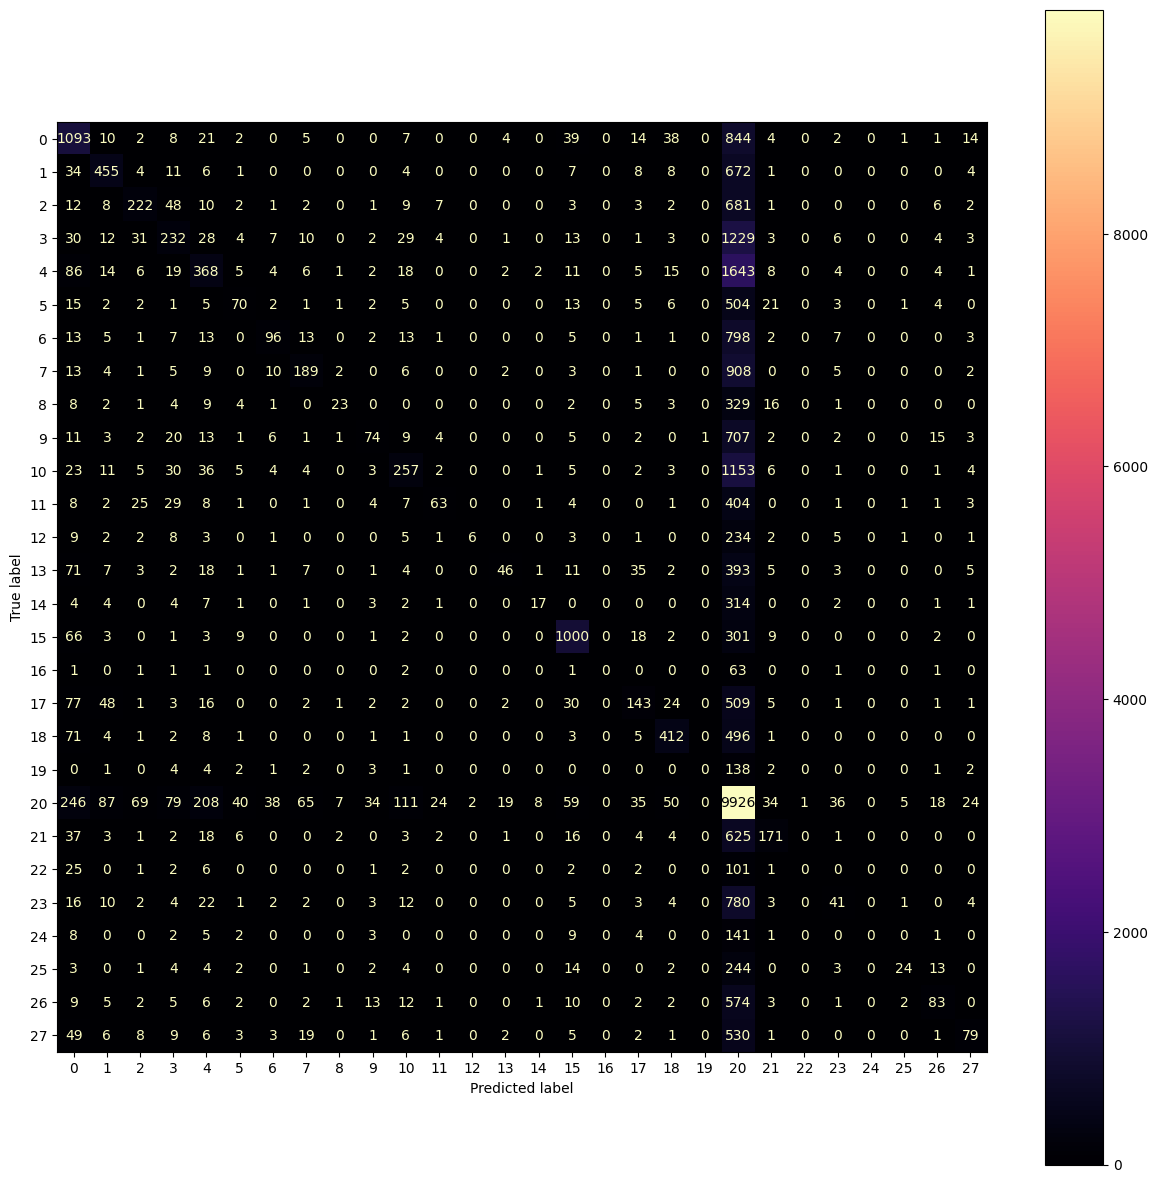

In [19]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.6099988359911536
Accuracy: 0.6099988359911536
Precision (Weighted): 0.6049424023118177
F1 Score (Weighted): 0.6030558816074075
F1 Score (Macro): 0.5683022429103906
              precision    recall  f1-score   support

           0       0.55      0.32      0.40      3788
           1       0.60      0.59      0.60      7610
           2       0.57      0.57      0.57     11225
           3       0.66      0.75      0.70     11741

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.57     34364
weighted avg       0.60      0.61      0.60     34364



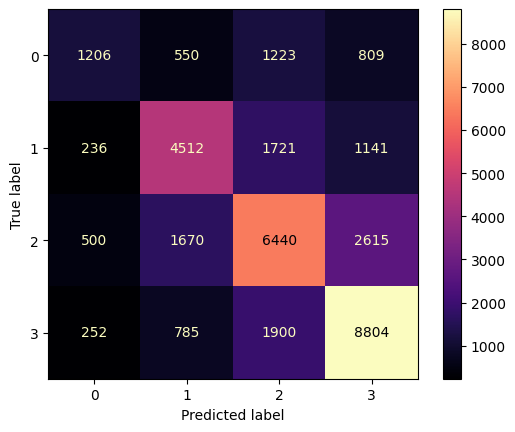

In [20]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>cross validation</h2>
<body>from sklearn.model_selection import cross_val_score</body>

<h2>Decision Tree (tree.DecisionTreeClassifier) with the default parameters.</h2>

In [21]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/DT1_model.pickle')):
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)


if (os.path.exists('models/DT2_model.pickle')):

    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.5958852287277383
Accuracy: 0.5958852287277383
Precision (Weighted): 0.6139015108282412
F1 Score (Weighted): 0.5930732994666306
F1 Score (Macro): 0.5165592167258867
              precision    recall  f1-score   support

           0       0.57      0.83      0.68      2109
           1       0.59      0.80      0.68      1215
           2       0.45      0.71      0.55      1020
           3       0.40      0.59      0.48      1652
           4       0.45      0.57      0.50      2224
           5       0.47      0.57      0.51       663
           6       0.46      0.53      0.49       981
           7       0.57      0.62      0.60      1160
           8       0.47      0.55      0.51       408
           9       0.42      0.44      0.43       882
          10       0.53      0.47      0.50      1556
          11       0.55      0.42      0.47       564
          12       0.48      0.39      0.43       284
          13       0.56      0.46      0.51       616
    

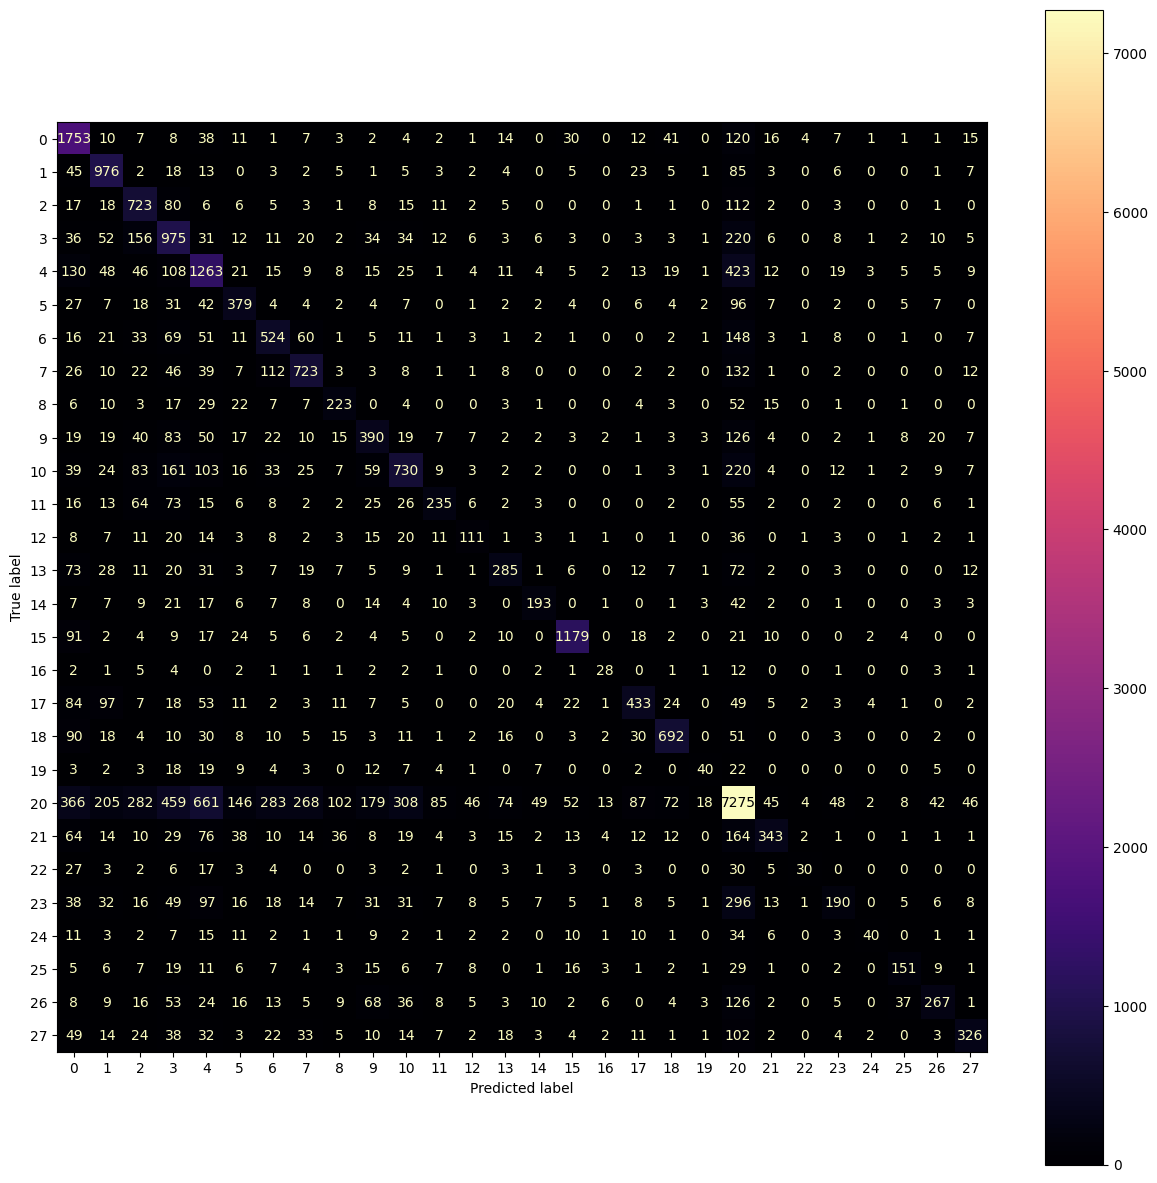

In [22]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')


Score for Sentiment: 0.7168548480968455
Accuracy: 0.7168548480968455
Precision (Weighted): 0.7286853435046113
F1 Score (Weighted): 0.7193334158040113
F1 Score (Macro): 0.7027353268711758
              precision    recall  f1-score   support

           0       0.56      0.71      0.63      3788
           1       0.67      0.77      0.72      7610
           2       0.72      0.66      0.69     11225
           3       0.84      0.73      0.78     11741

    accuracy                           0.72     34364
   macro avg       0.69      0.72      0.70     34364
weighted avg       0.73      0.72      0.72     34364



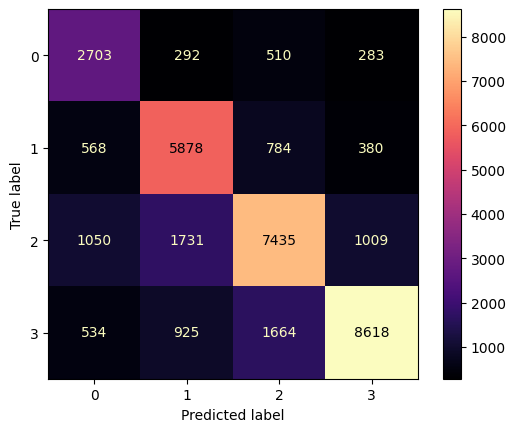

In [23]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.</h2>

In [24]:
classifier = MLPClassifier()
if (os.path.exists('models/MLP1_model.pickle')):
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP1 = classifier.fit(X_train, yemo_train)
    with open('models/MLP1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MLP2_model.pickle')):
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP2 = classifier.fit(X_train,ysent_train)
    with open('models/MLP2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.5817425212431615
Accuracy: 0.5817425212431615
Precision (Weighted): 0.5753658162449137
F1 Score (Weighted): 0.5763039646934391
F1 Score (Macro): 0.508933135740566
              precision    recall  f1-score   support

           0       0.64      0.69      0.67      2109
           1       0.65      0.66      0.66      1215
           2       0.54      0.54      0.54      1020
           3       0.45      0.41      0.43      1652
           4       0.48      0.38      0.43      2224
           5       0.46      0.41      0.43       663
           6       0.52      0.44      0.48       981
           7       0.58      0.50      0.54      1160
           8       0.41      0.55      0.47       408
           9       0.43      0.41      0.42       882
          10       0.50      0.48      0.49      1556
          11       0.48      0.45      0.47       564
          12       0.43      0.44      0.43       284
          13       0.51      0.42      0.46       616
     

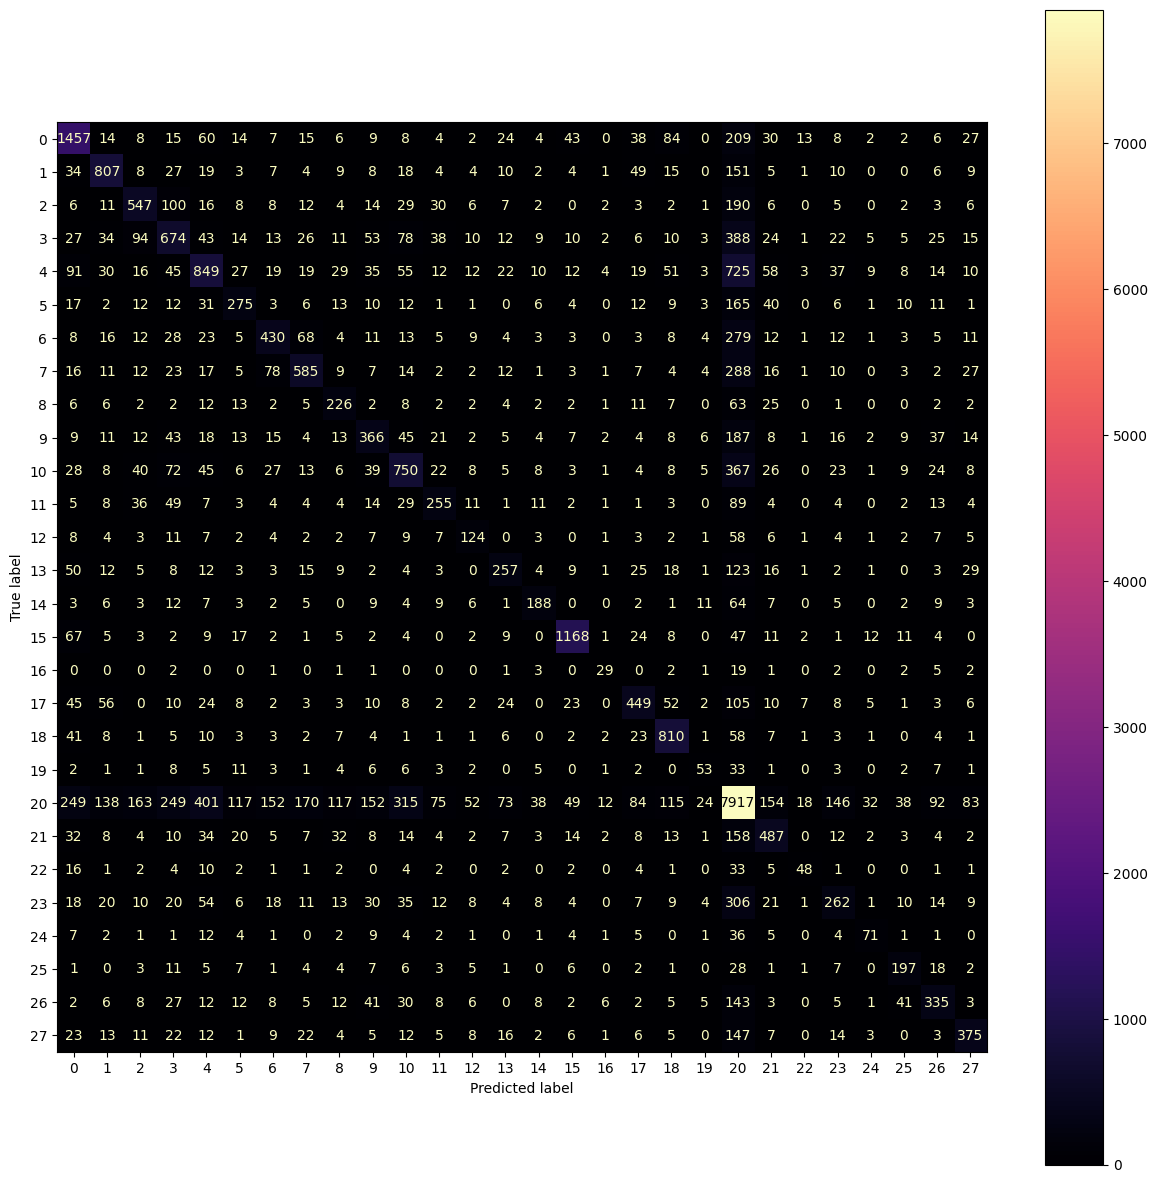

In [25]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.5593935513909906
Accuracy: 0.5593935513909906
Precision (Weighted): 0.564493642942737
F1 Score (Weighted): 0.5435704794210678
F1 Score (Macro): 0.48310908613912584
              precision    recall  f1-score   support

           0       0.52      0.13      0.21      3788
           1       0.56      0.45      0.50      7610
           2       0.48      0.65      0.55     11225
           3       0.66      0.69      0.67     11741

    accuracy                           0.56     34364
   macro avg       0.56      0.48      0.48     34364
weighted avg       0.56      0.56      0.54     34364



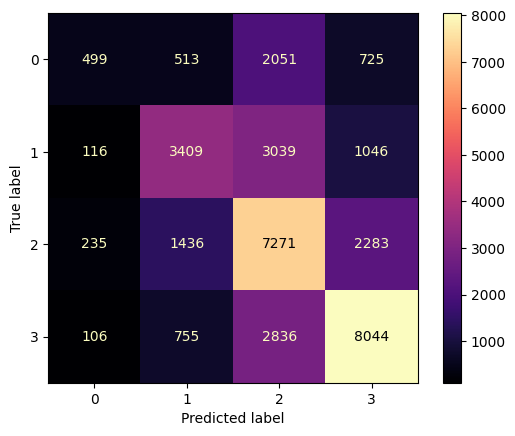

In [26]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1


In [27]:
parameters = {"alpha":(0.5,0,0.36,1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/MNB1GridCV_model.pickle')):
    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2GridCV_model.pickle')):
    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<h2>Decision Tree Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples


In [28]:
parameters = {"criterion":("gini","entropy"),"max_depth":(100,3),"min_samples_split":(12,5,30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/DT1GridCV_model.pickle')):
    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/DT2GridCV_model.pickle')):
    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.4044639513068846
Accuracy: 0.5071586544057735
Precision (Weighted): 0.5071414074807831
F1 Score (Weighted): 0.4649867317531462
F1 Score (Macro): 0.3614888338692258
              precision    recall  f1-score   support

           0       0.59      0.56      0.58      2109
           1       0.61      0.66      0.64      1215
           2       0.46      0.32      0.38      1020
           3       0.36      0.19      0.25      1652
           4       0.42      0.19      0.26      2224
           5       0.41      0.21      0.28       663
           6       0.45      0.22      0.30       981
           7       0.55      0.27      0.36      1160
           8       0.46      0.30      0.36       408
           9       0.42      0.15      0.22       882
          10       0.44      0.21      0.28      1556
          11       0.52      0.26      0.34       564
          12       0.44      0.1

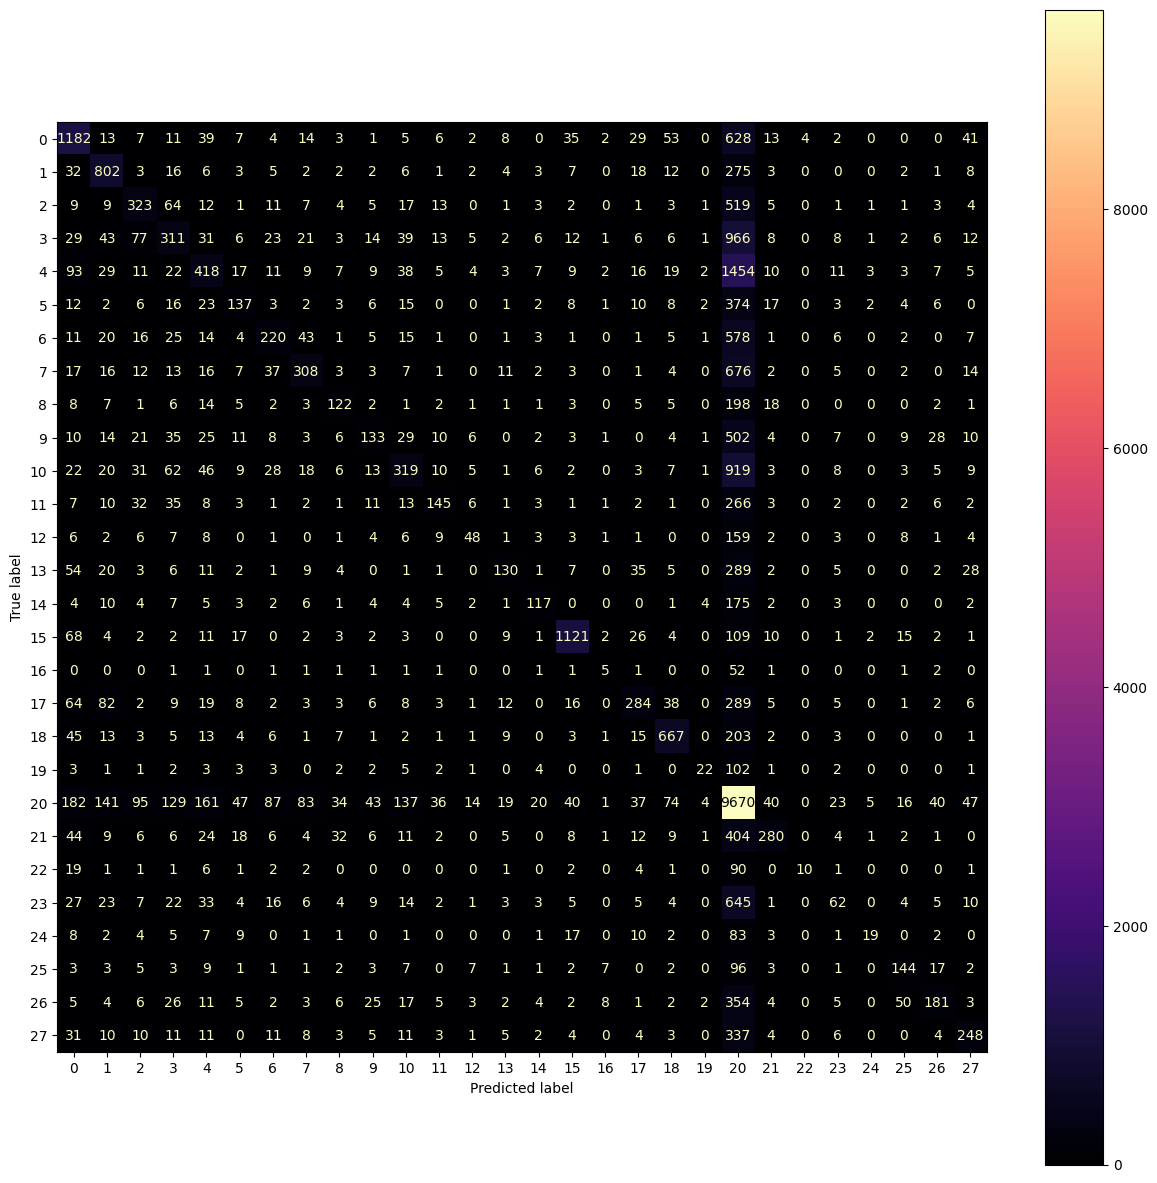

In [29]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.515219404662324
Accuracy: 0.6200966127342568
Precision (Weighted): 0.665287416181215
F1 Score (Weighted): 0.621553398205697
F1 Score (Macro): 0.5937599209388764
              precision    recall  f1-score   support

           0       0.53      0.44      0.48      3788
           1       0.68      0.49      0.57      7610
           2       0.51      0.79      0.62     11225
           3       0.85      0.60      0.70     11741

    accuracy                           0.62     34364
   macro avg       0.64      0.58      0.59     34364
weighted avg       0.67      0.62      0.62     34364



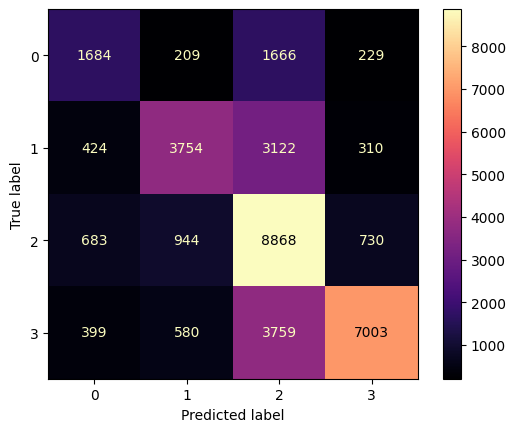

In [30]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [31]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True, verbose=True,max_iter=5)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters,n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/MLP1GridCV_model.pickle')):
        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/MLP1GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/MLP2GridCV_model.pickle')):
        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/MLP2GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


Accuracy: 0.46013269700849724
Precision (Weighted): 0.43994341595433817
F1 Score (Weighted): 0.3806753179944684
F1 Score (Macro): 0.2369588633388479
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      2109
           1       0.55      0.66      0.60      1215
           2       0.44      0.26      0.33      1020
           3       0.20      0.05      0.08      1652
           4       0.36      0.09      0.15      2224
           5       0.67      0.01      0.01       663
           6       0.44      0.10      0.17       981
           7       0.46      0.19      0.26      1160
           8       0.57      0.07      0.13       408
           9       0.40      0.00      0.00       882
          10       0.33      0.11      0.16      1556
          11       0.50      0.04      0.07       564
          12       1.00      0.01      0.02       284
          13       0.64      0.06      0.11       616
          14       0.51      0.32      0

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

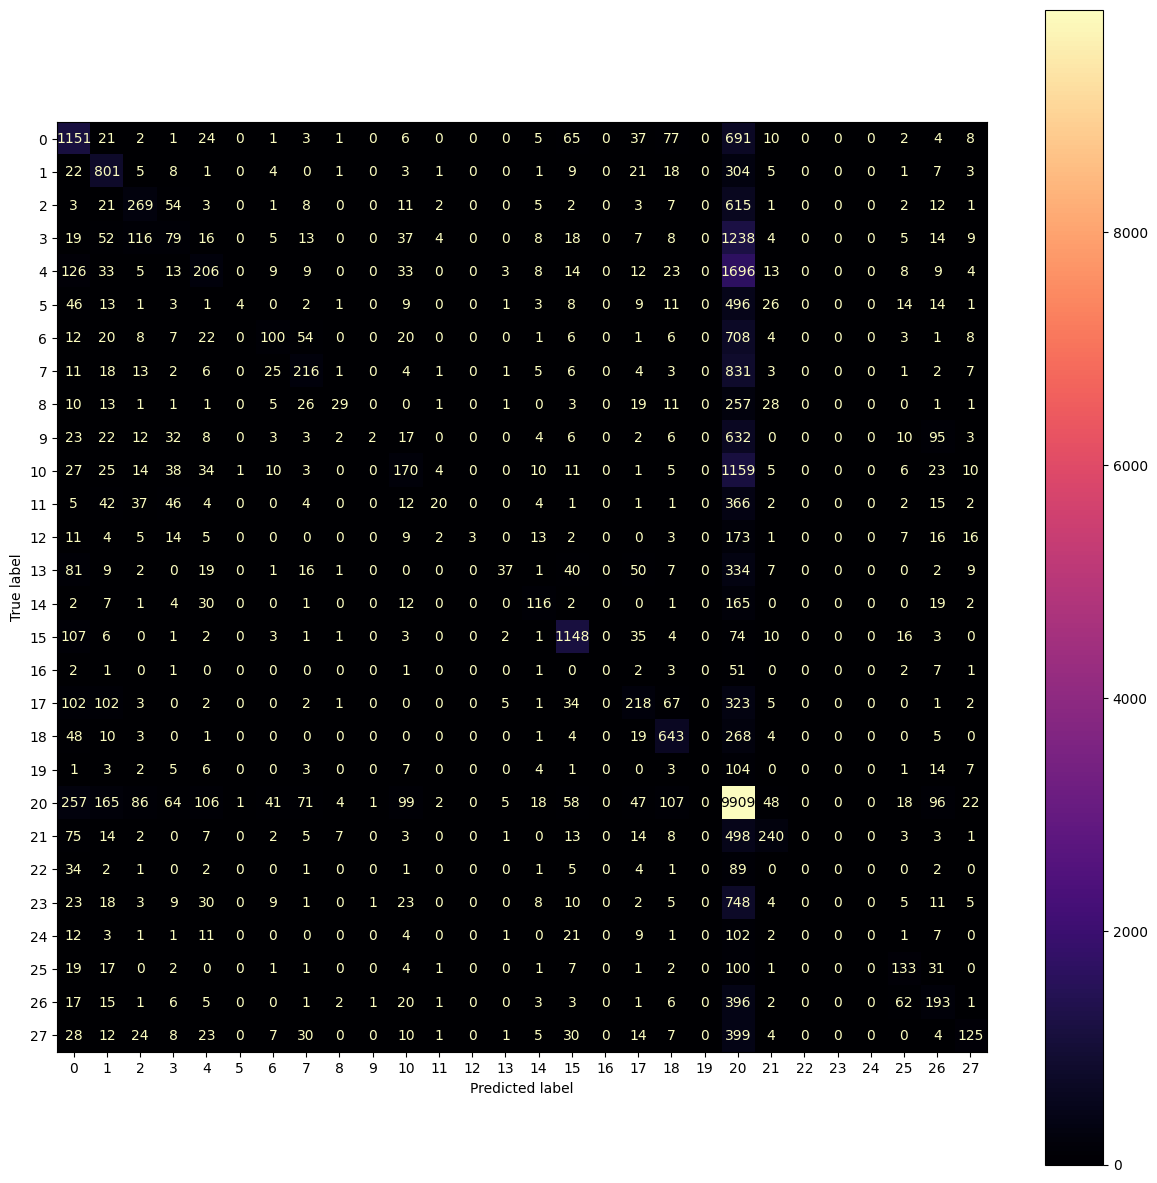

In [32]:
if (os.path.exists('models/MLP1GridCV_model.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

Accuracy: 0.6316203003142824
Precision (Weighted): 0.6296869713379153
F1 Score (Weighted): 0.6254352761562126
F1 Score (Macro): 0.5876889386825104
              precision    recall  f1-score   support

           0       0.58      0.32      0.41      3788
           1       0.63      0.59      0.61      7610
           2       0.57      0.64      0.60     11225
           3       0.70      0.75      0.73     11741

    accuracy                           0.63     34364
   macro avg       0.62      0.58      0.59     34364
weighted avg       0.63      0.63      0.63     34364

Best estimator (Sentiment): MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(5, 10), max_iter=5, verbose=True), Best Score: 0.5612705192148834


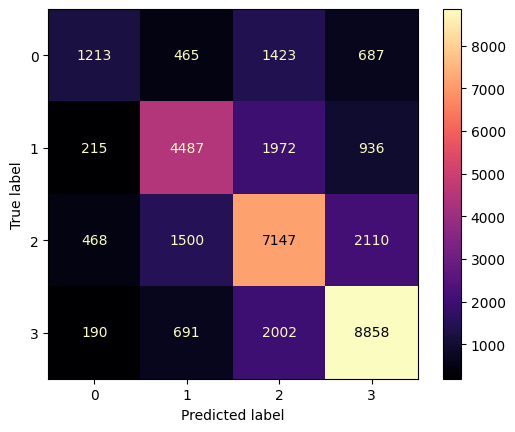

In [33]:
if (os.path.exists('models/MLP2GridCV_model.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h3>2.5</h3>
Test/Training split: 80/20 -> 50/50
Anticipated effect: increased accuracy but poor generalization


In [34]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1])  #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2])  #change 0 to the column of sentiment with no separation



In [35]:
X_train, X_test, yemo_train, yemo_test, ysent_train, ysent_test = train_test_split(X, encodedEmo, encodedSentiment,test_size=0.5, train_size=0.5)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) using new test train split</h2>

In [36]:
classifier = MultinomialNB()
if (os.path.exists('models/new_split/MNB1_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")

else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.44948201606332205
Accuracy: 0.44948201606332205
Precision (Weighted): 0.4962148930640188
F1 Score (Weighted): 0.39090099786694954
F1 Score (Macro): 0.25209275970254535
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      5289
           1       0.62      0.42      0.50      3059
           2       0.53      0.21      0.30      2631
           3       0.43      0.17      0.25      4250
           4       0.46      0.19      0.26      5649
           5       0.45      0.13      0.21      1794
           6       0.54      0.13      0.20      2425
           7       0.55      0.19      0.28      2966
           8       0.60      0.08      0.14      1076
           9       0.51      0.10      0.17      2302
          10       0.44      0.17      0.25      3779
          11       0.60      0.15      0.24      1427
          12       0.63      0.04      0.07       722
          13       0.56      0.09      0.15      1535


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

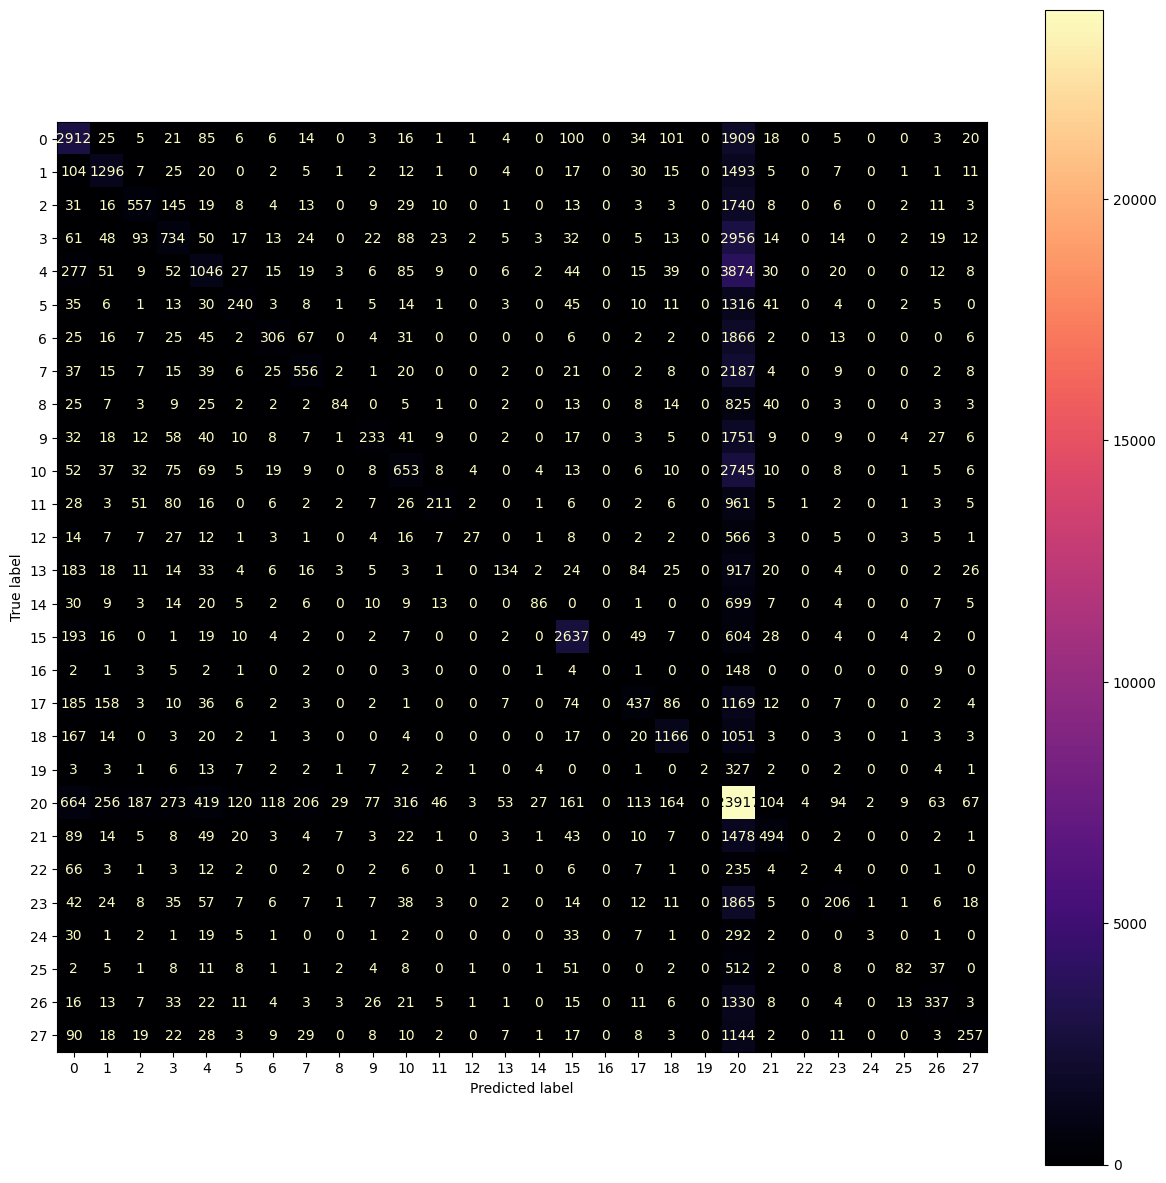

In [37]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.6175066930508671
Accuracy: 0.6175066930508671
Precision (Weighted): 0.6124515635994698
F1 Score (Weighted): 0.6116021109708348
F1 Score (Macro): 0.5784332203478391
              precision    recall  f1-score   support

           0       0.55      0.34      0.42      9458
           1       0.61      0.61      0.61     19256
           2       0.57      0.57      0.57     27492
           3       0.67      0.75      0.71     29704

    accuracy                           0.62     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.62      0.61     85910



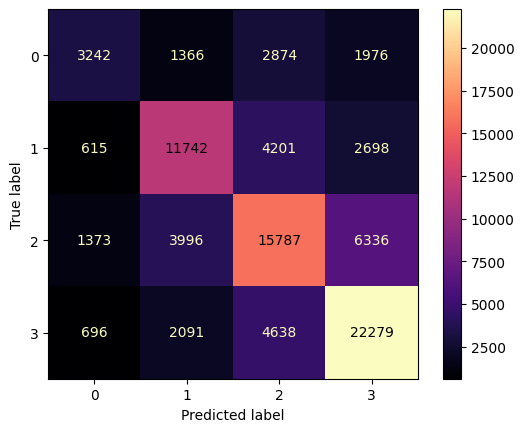

In [38]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree (tree.DecisionTreeClassifier) using new test train split</h2>

In [39]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/new_split/DT1_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.6220579676405541
Accuracy: 0.6220579676405541
Precision (Weighted): 0.6325495217704619
F1 Score (Weighted): 0.6165574274747251
F1 Score (Macro): 0.5401408658454327
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      5289
           1       0.60      0.84      0.70      3059
           2       0.49      0.72      0.58      2631
           3       0.43      0.58      0.49      4250
           4       0.49      0.55      0.52      5649
           5       0.51      0.57      0.54      1794
           6       0.52      0.57      0.54      2425
           7       0.61      0.62      0.62      2966
           8       0.53      0.52      0.53      1076
           9       0.49      0.45      0.47      2302
          10       0.57      0.49      0.53      3779
          11       0.62      0.44      0.51      1427
          12       0.55      0.38      0.45       722
          13       0.57      0.41      0.48      1535
    

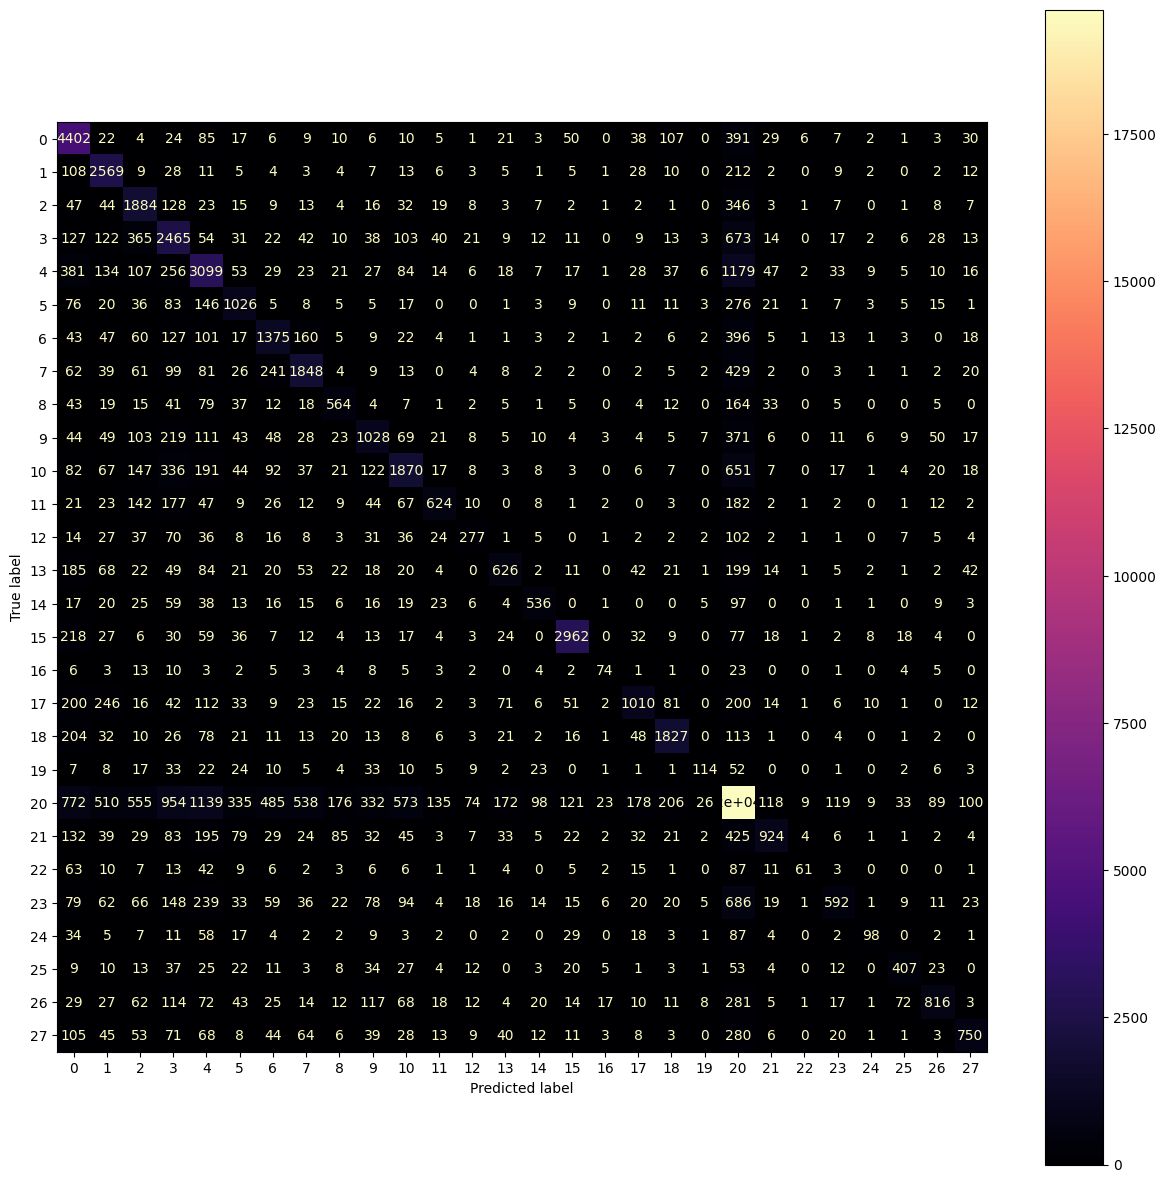

In [40]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.7398323827261087
Accuracy: 0.7398323827261087
Precision (Weighted): 0.7473023508556362
F1 Score (Weighted): 0.7415811980554632
F1 Score (Macro): 0.725472110212816
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      9458
           1       0.70      0.79      0.74     19256
           2       0.73      0.70      0.71     27492
           3       0.84      0.76      0.80     29704

    accuracy                           0.74     85910
   macro avg       0.72      0.74      0.73     85910
weighted avg       0.75      0.74      0.74     85910



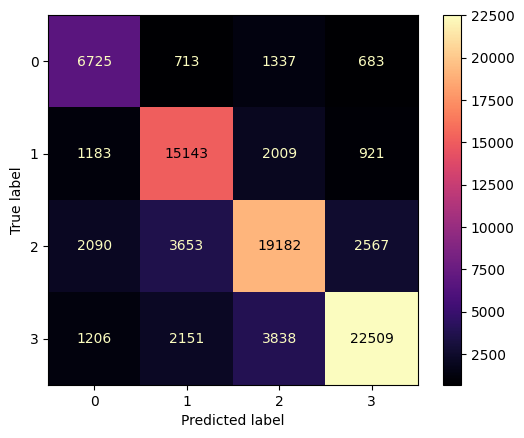

In [41]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) using new test train split</h2>

<b>Did not converge timed out</b>

In [42]:
classifier = MLPClassifier()
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP1 = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP2 = classifier.fit(X_train, ysent_train)
        with open('models/new_split/MLP2_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


Score for Emotion: 0.5974741008031661
Accuracy: 0.5974741008031661
Precision (Weighted): 0.5895823309584535
F1 Score (Weighted): 0.5889461154044602
F1 Score (Macro): 0.5216453976079813
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      5289
           1       0.65      0.71      0.68      3059
           2       0.60      0.47      0.53      2631
           3       0.49      0.40      0.44      4250
           4       0.55      0.38      0.45      5649
           5       0.53      0.46      0.49      1794
           6       0.56      0.40      0.47      2425
           7       0.59      0.57      0.58      2966
           8       0.47      0.55      0.51      1076
           9       0.48      0.35      0.41      2302
          10       0.51      0.46      0.49      3779
          11       0.50      0.46      0.48      1427
          12       0.41      0.51      0.46       722
          13       0.50      0.41      0.45      1535
    

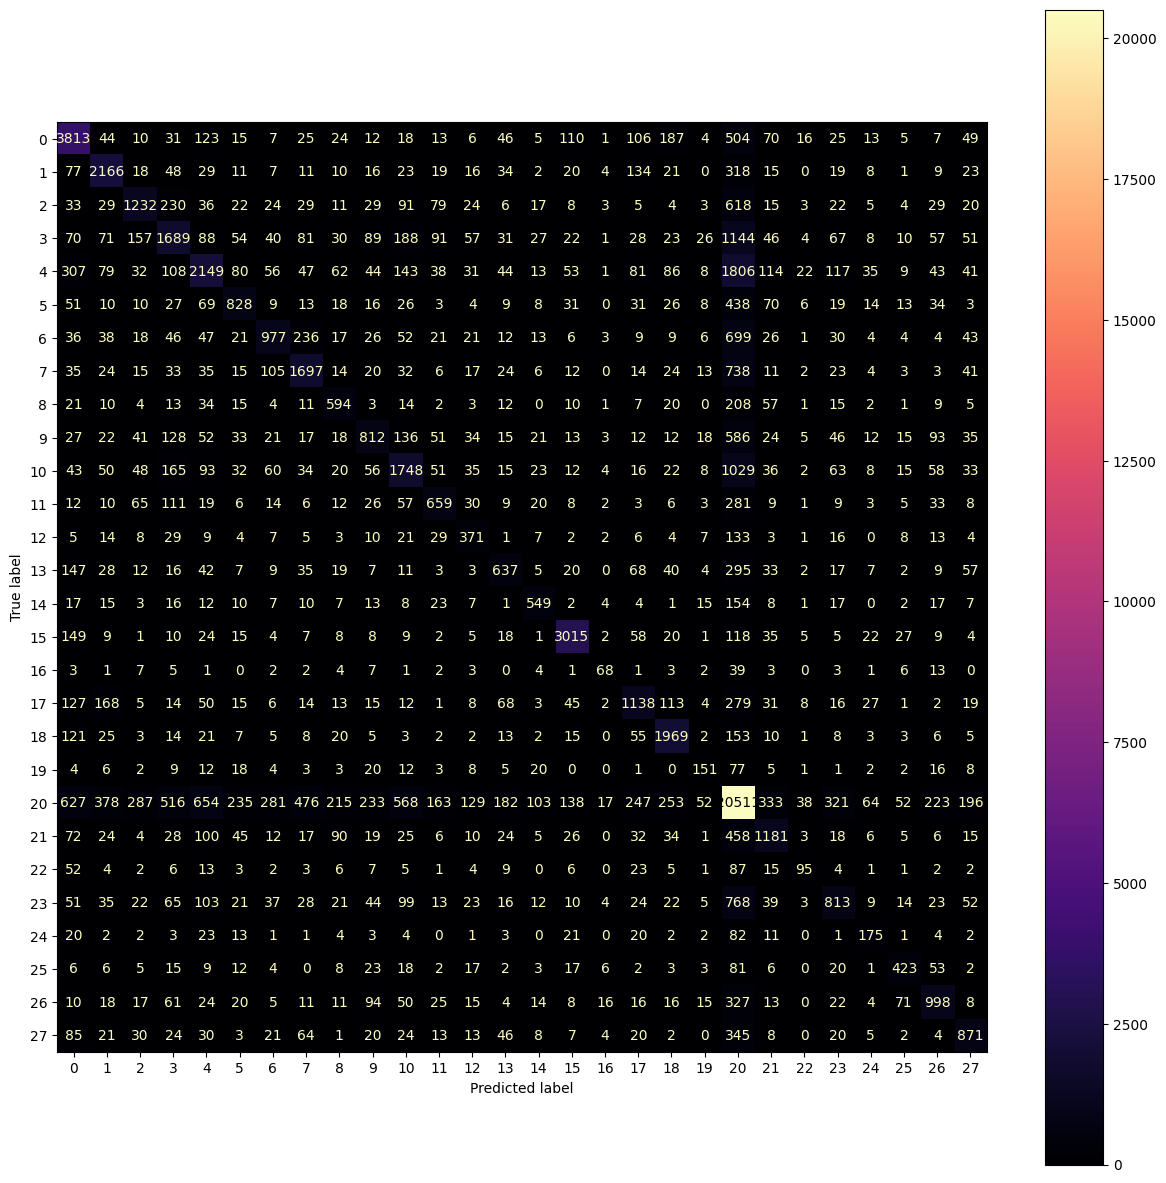

In [43]:

if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.predict(X_test)
    print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
    metrics(yemo_test, y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
    fig, ax = plt.subplots(figsize=(15, 15))
    cmp.plot(ax=ax, cmap='magma')
else:
    print("skipped")

Score for Sentiment: 0.7261901990455127
Accuracy: 0.7261901990455127
Precision (Weighted): 0.7252181446922188
F1 Score (Weighted): 0.7254372076720162
F1 Score (Macro): 0.7046115271995069
              precision    recall  f1-score   support

           0       0.65      0.58      0.61      9458
           1       0.71      0.73      0.72     19256
           2       0.69      0.70      0.69     27492
           3       0.79      0.80      0.79     29704

    accuracy                           0.73     85910
   macro avg       0.71      0.70      0.70     85910
weighted avg       0.73      0.73      0.73     85910



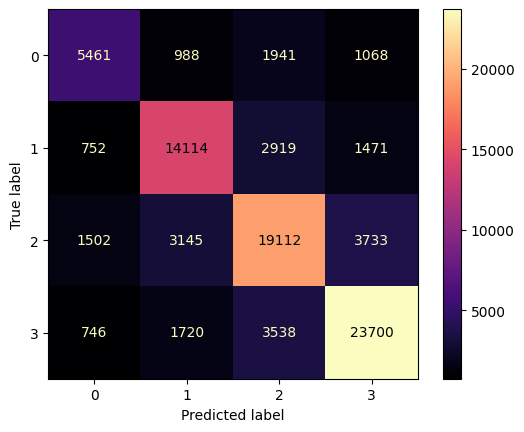

In [44]:
if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.predict(X_test)

    print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
    metrics(ysent_test, y_sent_predict)
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1

In [45]:
parameters = {"alpha": (0.5, 0, 0.36, 1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/MNB1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): MultinomialNB(alpha=0.5), Best Score: 0.3905984755012737
Accuracy: 0.4871959026888604
Precision (Weighted): 0.49020247108071296
F1 Score (Weighted): 0.4570456889389065
F1 Score (Macro): 0.34785986730078877
              precision    recall  f1-score   support

           0       0.54      0.62      0.58      5289
           1       0.60      0.60      0.60      3059
           2       0.50      0.33      0.40      2631
           3       0.40      0.24      0.30      4250
           4       0.46      0.25      0.32      5649
           5       0.40      0.28      0.33      1794
           6       0.47      0.25      0.32      2425
           7       0.51      0.31      0.39      2966
           8       0.57      0.22      0.31      1076
           9       0.45      0.19      0.27      2302
          10       0.42      0.28      0.33      3779
          11       0.50      0.25      0.34      1427
          12       0.56      0.13      0.21       722
          1

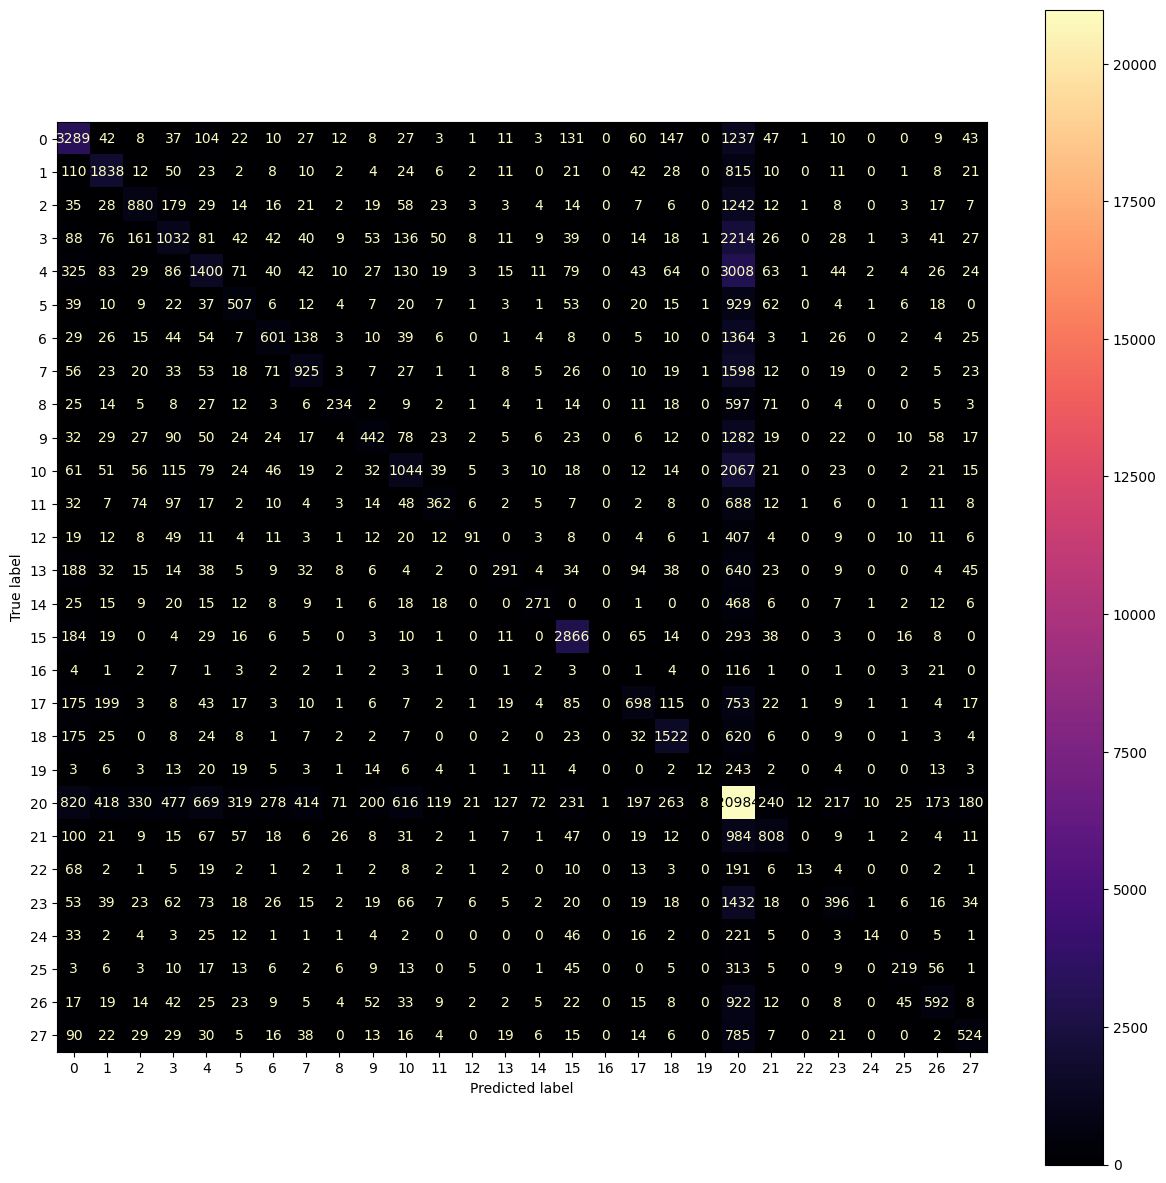

In [46]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.543696292227927
Accuracy: 0.6175066930508671
Precision (Weighted): 0.6124515635994698
F1 Score (Weighted): 0.6116021109708348
F1 Score (Macro): 0.5784332203478391
              precision    recall  f1-score   support

           0       0.55      0.34      0.42      9458
           1       0.61      0.61      0.61     19256
           2       0.57      0.57      0.57     27492
           3       0.67      0.75      0.71     29704

    accuracy                           0.62     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.62      0.61     85910



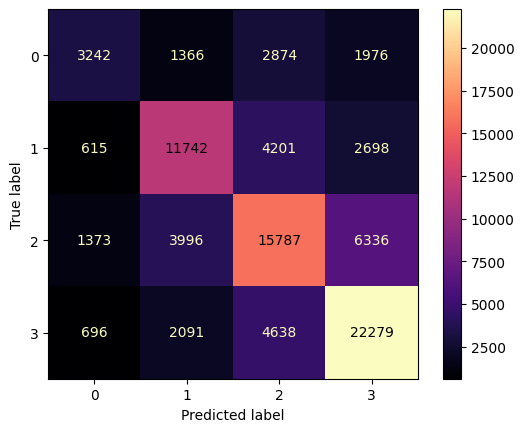

In [47]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>DecisionTree Classifier found using GridSearchCV and new test train split </h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples

In [48]:
parameters = {"criterion": ("gini", "entropy"), "max_depth": (100, 3), "min_samples_split": (12, 5, 30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/DT1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.3984285880572692
Accuracy: 0.47079501804213714
Precision (Weighted): 0.46206054517919853
F1 Score (Weighted): 0.42525225071950024
F1 Score (Macro): 0.32251977800323006
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      5289
           1       0.57      0.60      0.59      3059
           2       0.46      0.28      0.35      2631
           3       0.30      0.15      0.20      4250
           4       0.36      0.16      0.22      5649
           5       0.36      0.15      0.21      1794
           6       0.41      0.21      0.27      2425
           7       0.46      0.22      0.30      2966
           8       0.44      0.26      0.33      1076
           9       0.34      0.13      0.19      2302
          10       0.34      0.16      0.21      3779
          11       0.45      0.21      0.29      1427
          12       0.51     

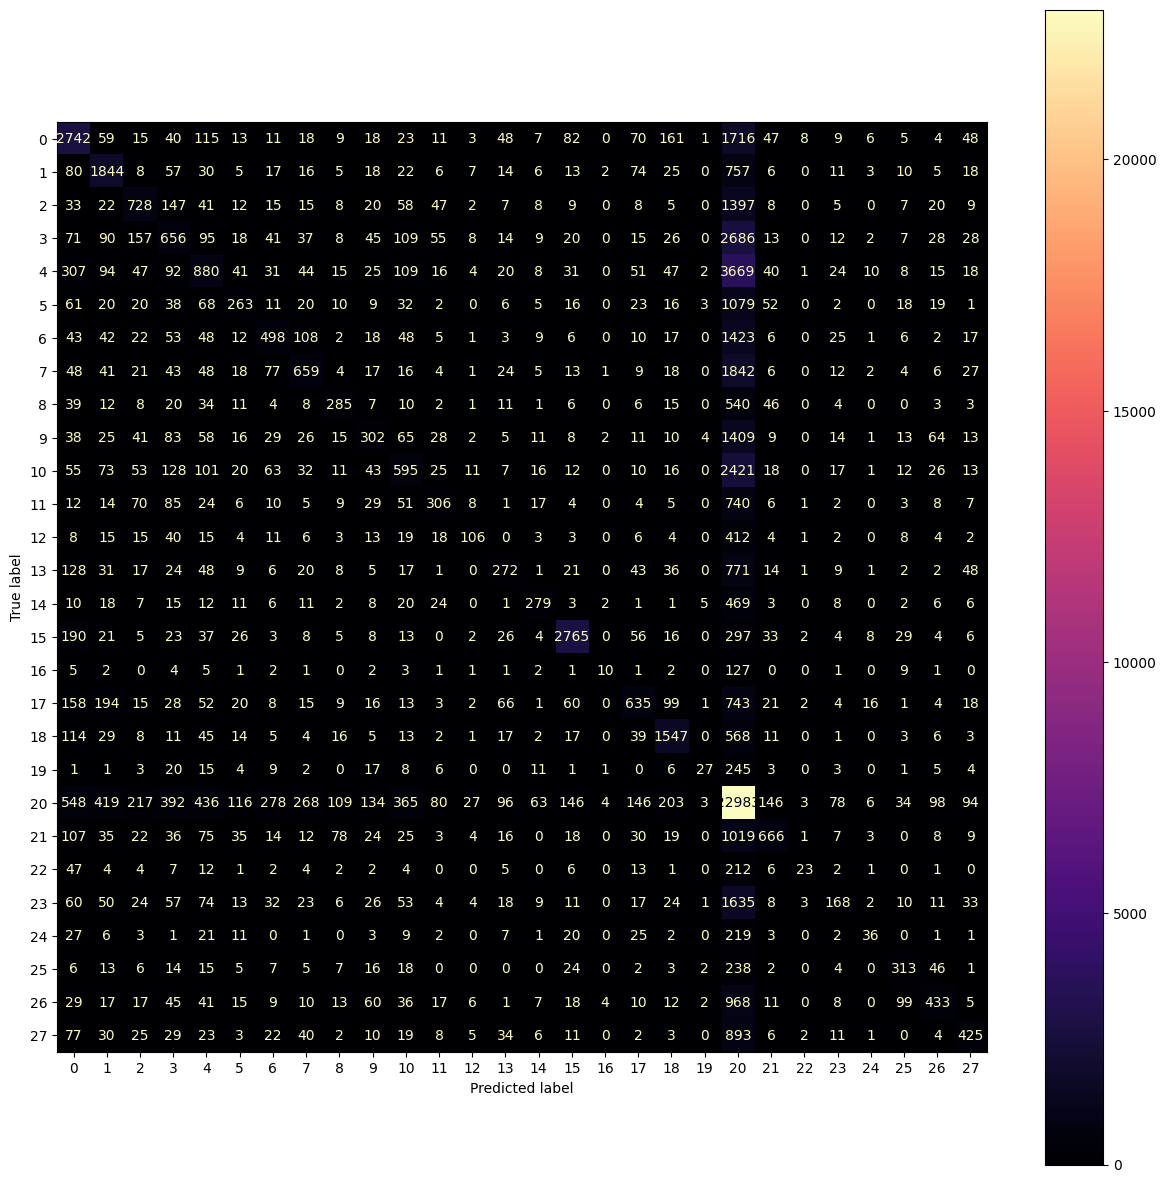

In [49]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.49976719823070653
Accuracy: 0.5844139215458037
Precision (Weighted): 0.6303919907556211
F1 Score (Weighted): 0.5830324761687191
F1 Score (Macro): 0.5494627898089446
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      9458
           1       0.65      0.45      0.53     19256
           2       0.47      0.78      0.59     27492
           3       0.80      0.57      0.67     29704

    accuracy                           0.58     85910
   macro avg       0.61      0.54      0.55     85910
weighted avg       0.63      0.58      0.58     85910



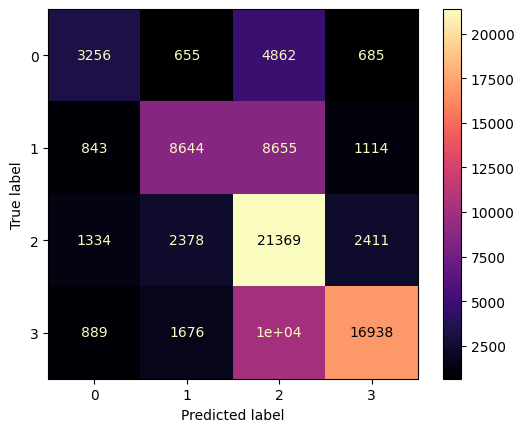

In [50]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [51]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True,verbose=True, max_iter=5)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters, n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/new_split/MLP2GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


Accuracy: 0.43606099406355486
Precision (Weighted): 0.3872269422354017
F1 Score (Weighted): 0.3441716280276635
F1 Score (Macro): 0.20428947383188004
              precision    recall  f1-score   support

           0       0.47      0.55      0.51      5289
           1       0.56      0.62      0.59      3059
           2       0.38      0.09      0.14      2631
           3       0.26      0.02      0.03      4250
           4       0.41      0.06      0.10      5649
           5       0.25      0.05      0.09      1794
           6       0.32      0.09      0.14      2425
           7       0.27      0.13      0.18      2966
           8       0.45      0.15      0.22      1076
           9       0.00      0.00      0.00      2302
          10       0.29      0.02      0.03      3779
          11       0.57      0.11      0.18      1427
          12       1.00      0.00      0.00       722
          13       0.28      0.01      0.03      1535
          14       0.00      0.00      0

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms


Best estimator (Emotion): MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(5, 10), max_iter=5, verbose=True), Best Score: 0.4037015481317658
Accuracy: 0.43606099406355486
Precision (Weighted): 0.3872269422354017
F1 Score (Weighted): 0.3441716280276635
F1 Score (Macro): 0.20428947383188004
              precision    recall  f1-score   support

           0       0.47      0.55      0.51      5289
           1       0.56      0.62      0.59      3059
           2       0.38      0.09      0.14      2631
           3       0.26      0.02      0.03      4250
           4       0.41      0.06      0.10      5649
           5       0.25      0.05      0.09      1794
           6       0.32      0.09      0.14      2425
           7       0.27      0.13      0.18      2966
           8       0.45      0.15      0.22      1076
           9       0.00      0.00      0.00      2302
          10       0.29      0.02      0.03      3779
          11     

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

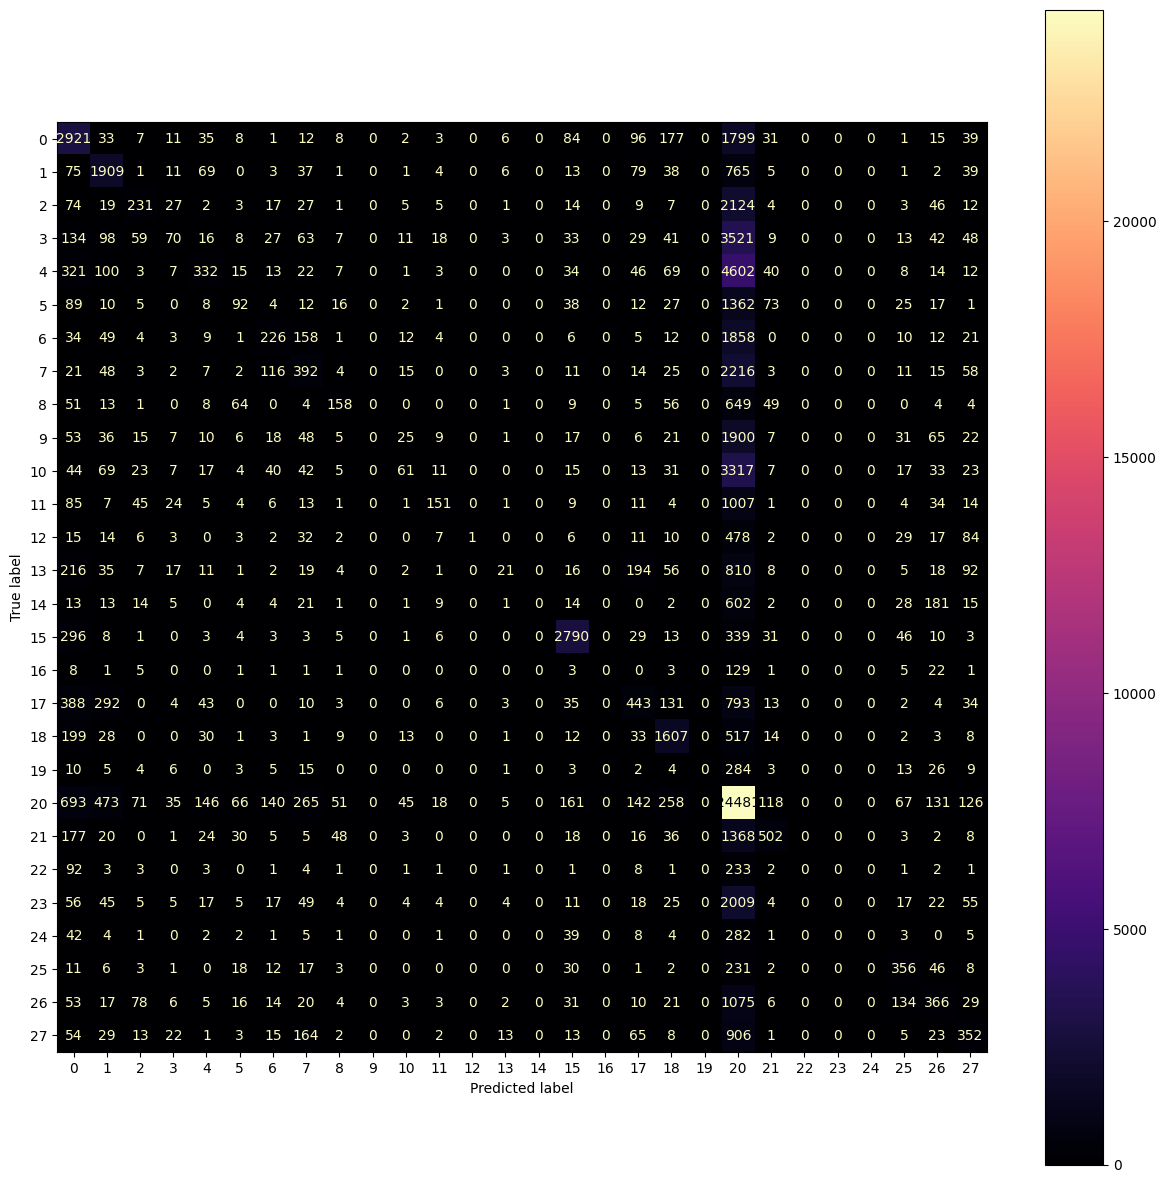

In [52]:
if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

Accuracy: 0.6050634384821325
Precision (Weighted): 0.6050983139502703
F1 Score (Weighted): 0.6014548273495183
F1 Score (Macro): 0.5634845379065029
              precision    recall  f1-score   support

           0       0.51      0.32      0.39      9458
           1       0.59      0.57      0.58     19256
           2       0.53      0.61      0.57     27492
           3       0.71      0.71      0.71     29704

    accuracy                           0.61     85910
   macro avg       0.59      0.55      0.56     85910
weighted avg       0.61      0.61      0.60     85910

Best estimator (Sentiment): MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(5, 5),
              max_iter=5, verbose=True), Best Score: 0.5505296240251426


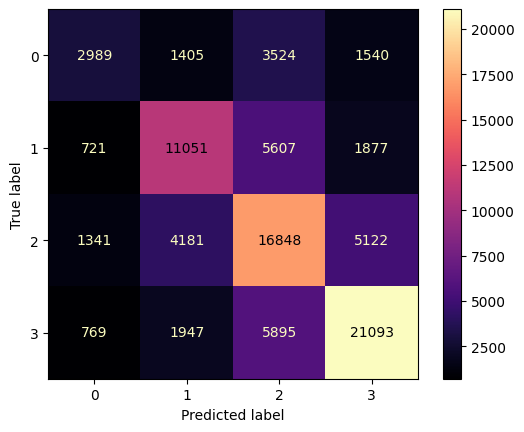

In [53]:
if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h3>3. Embedding as features</h3>

requires install of library gensim

pip install gensim

https://radimrehurek.com/gensim/models/word2vec.html


In [54]:
# result.most_similar("cat")

In [55]:
if (os.path.exists('models/word2vec.pickle')):
    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("word2vec-google-news-300")
    with open('models/word2vec.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)

pickle file used


In [56]:
nltk.download('punkt')
#post.str.lower()
tokenized_word = [word_tokenize(i) for i in post]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
post_tokens = [post_tokens for post_tokens in tokenized_word] #http://librarycarpentry.org/lc-tdm/aio/index.html
print("Number of tokens in Reddit posts:")
tokens_list = []
for i in post_tokens:
    for j in i:
        tokens_list.append(j)
print(len(tokens_list))

Number of tokens in Reddit posts:
2642128


In [66]:
X_embed_train,X_embed_test, y_embed_emotions_train, y_embed_emotions_test, y_embed_sentiments_train, y_embed_sentiments_test= train_test_split(post_tokens, encodedEmo, encodedSentiment, test_size = 0.2, train_size=0.8)

In [67]:
# average_embedding_training = []
# average_embedding_test = []
# average_embedding_total = []
# key_error = False
# missed = 0
# # model = gensim.models
# model = gensim.downloader.load("word2vec-google-news-300")

# for post in X_train_emb:
#     token_embeddings = []
#     for words in post:
#         key_error = False
#         try:
#             token_embeddings.append(model[words])
#         except KeyError:
#             key_error = True
#             missed = missed + 1
#     average_embedding_training.append(np.mean(token_embeddings,axis=0))

# print('Hit rate of training set:')
# print(1 - (missed/len(tokens_list)))
    
# missed=0
    
# for post in X_test_emb:
#     token_embeddings = []
#     for words in post:
#         key_error = False
#         try:
#             token_embeddings.append(model[words])
#         except KeyError:
#             key_error = True
#             missed = missed + 1
#     average_embedding_test.append(np.mean(token_embeddings,axis=0))

# print('Hit rate of test set:')
# print(1 - (missed/len(tokens_list)))

# for i in range(len(average_embedding_training)):
#     average_embedding_training[i] = np.array(average_embedding_training[i])
# for i in range(len(average_embedding_test)):
#     average_embedding_test[i] = np.array(average_embedding_test[i])

posts_tokens_in_model_training = [] # List of posts but with only the tokens that are in the model
number_tokens_after_removal_training = 0
# Removing words that are not in the Google model
for post in X_embed_train:
    post_with_unmodeled_words_removed_train = [] # Post with the unmodeled words removed
    for word in post:
        if word in model:
            post_with_unmodeled_words_removed_train.append(word)
        else:
            continue
    posts_tokens_in_model_training.append(post_with_unmodeled_words_removed_train)
    number_tokens_after_removal_training += len(post_with_unmodeled_words_removed_train)

# Calculating the average embed for each post in the training set
average_embeds_train = []
for post in posts_tokens_in_model_training:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) # Get the embedding for each word in the post, model[word] returns the embedding for the word
    # axis = 0 means that we are averaging the rows
    average_embeds_train.append(np.mean(token_embeddings,axis=0)) # use np.mean() to get the average of the embeddings for the words in the post
print(f"Example of averaged posts: {average_embeds_train[0]}")

# ~~~~~~~~~~~Test set:
posts_tokens_in_model_test = [] # List of posts but with only the tokens that are in the model
number_tokens_after_removal_test = 0
# Removing words that are not in the Google model
for post in X_embed_test:
    post_with_unmodeled_words_removed_test = [] # Post with the unmodeled words removed
    for word in post:
        if word in model:
            post_with_unmodeled_words_removed_test.append(word)
        else:
            continue
    posts_tokens_in_model_test.append(post_with_unmodeled_words_removed_test)
    number_tokens_after_removal_test += len(post_with_unmodeled_words_removed_test)
    
# Calculating the average embed for each post in the test set
average_embeds_test = []
for post in posts_tokens_in_model_test:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) # Get the embedding for each word in the post, model[word] returns the embedding for the word
    average_embeds_test.append(np.mean(token_embeddings,axis=0)) # use np.mean() to get the average of the embeddings for the words in the post

# Setting the training and test sets to the average embeddings
X_embed_avg_train = average_embeds_train
X_embed_avg_test = average_embeds_test

#Remove empty posts from training and test sets and the corresponding labels

# Remove all empty posts from the training set (if the shape isn't 300 it's bad!)
for i in range(len(X_embed_avg_train)):
    if i >= len(X_embed_avg_train):
        break
    if X_embed_avg_train[i].shape == (300,):
        continue
    else:
        X_embed_avg_train.pop(i)
        y_embed_emotions_train = np.delete(y_embed_emotions_train, i)
        y_embed_sentiments_train = np.delete(y_embed_sentiments_train, i)

# Remove all empty posts from the test set (if the shape isn't 300 it's bad!)
for i in range(len(X_embed_avg_test)):
    if i >= len(X_embed_avg_test):
        break
    if X_embed_avg_test[i].shape == (300,):
        continue
    else:
        X_embed_avg_test.pop(i)
        y_embed_emotions_test = np.delete(y_embed_emotions_test, i)
        y_embed_sentiments_test = np.delete(y_embed_sentiments_test, i)

#print shape of training and test sets
print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
print(f"Shape of test set: {np.shape(X_embed_avg_test)}")

# Turn all the posts into regular np arrays since otherwise we get: ValueError: Setting an array element with a sequence.
for i in range(len(X_embed_avg_train)):
    X_embed_avg_train[i] = np.array(X_embed_avg_train[i])

for i in range(len(X_embed_avg_test)):
    X_embed_avg_test[i] = np.array(X_embed_avg_test[i])

Example of averaged posts: [ 8.90299454e-02  4.41023521e-02  5.40211983e-02  1.64713547e-01
 -5.94043732e-03  9.90804005e-03  7.27539062e-02 -4.50236015e-02
  7.40559911e-03  9.00878906e-02 -3.12474575e-02 -1.92464188e-01
 -2.80965175e-02 -1.23616539e-01 -1.85546875e-01  6.16048165e-02
  8.21940079e-02  1.15315758e-01  9.93143693e-02 -9.83072892e-02
 -4.58984375e-02  1.43229172e-01  1.37430832e-01 -7.24487305e-02
  7.42187500e-02  2.59399414e-03 -8.29671249e-02 -5.98958321e-02
  1.86564121e-02  4.15445976e-02 -1.51367188e-02  8.09326172e-02
 -2.66113281e-02 -6.42903671e-02  2.88899746e-02  1.38346357e-02
  9.49096680e-02  4.78210449e-02  2.24812832e-02  1.56901047e-01
  1.58528641e-01 -5.60709648e-02  2.39908859e-01 -3.24707031e-02
  1.13932295e-02  7.95898438e-02 -2.12300625e-02  8.13802108e-05
  6.84000626e-02  2.23414097e-02  4.34570312e-02  1.08306885e-01
 -2.38037109e-02 -3.91845703e-02 -3.45865898e-02  8.72802734e-02
  1.98415127e-02  2.10774746e-02  8.45642090e-02 -6.94020614e-0

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [70]:
# classifier = MLPClassifier()
classifier = MLPClassifier(max_iter=3)

if (os.path.exists('models/Embeddings_MLP_model25.pickle')):
    pickle_in = open('models/Embeddings_MLP_model25.pickle','rb')
    eclf = pickle.load(pickle_in)
    print('\pickle file used\'')
else:
    EMLP = classifier.fit(X_embed_avg_train, y_embed_emotions_train)
    with open('models/Embeddings_MLP_model25.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/Embeddings_MLP_model25.pickle','rb')
    clf1 = pickle.load(pickle_in)

print('done')        
        
if (os.path.exists('models/Embeddings_MLP_model2.pickle')):
    pickle_in = open('models/Embeddings_MLP_model2.pickle','rb')
    eclf2 = pickle.load(pickle_in)
    print('\pickle file used\'')
else:
    EMLP2 = classifier.fit(X_embed_avg_train, y_embed_sentiments_train)
    with open('models/Embeddings_MLP_model2.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/Embeddings_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)


done
\pickle file used'


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
